Importing libraries

In [1]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter
import numpy as np
nlp = spacy.load("en_core_web_sm")

Due to the the dataset containing over 5 million rows and 2 columns, the csv is opened as an iterator. Then, 1,000 rows are collected for analysis and modelling.

In [2]:
raw_data = pd.read_csv('data.csv', iterator=True)

In [3]:
data = raw_data.get_chunk(10000)
data.head(20)

,text,label
0,Apparently Prides Osteria had a rough summer a...,stars
1,This store is pretty good. Not as great as Wal...,stars
2,I called WVM on the recommendation of a couple...,stars
3,I've stayed at many Marriott and Renaissance M...,stars
4,The food is always great here. The service fro...,stars
5,"This place used to be a cool, chill place. Now...",useful
6,"The setting is perfectly adequate, and the foo...",stars
7,Probably one of the better breakfast sandwiche...,stars
8,I am definitely a fan of Sports Authority. Th...,stars
9,I work in the Pru and this is the most afforda...,stars


Visualizing all different classes that will be used to predict the type of review. A major class imbalance was discovered.

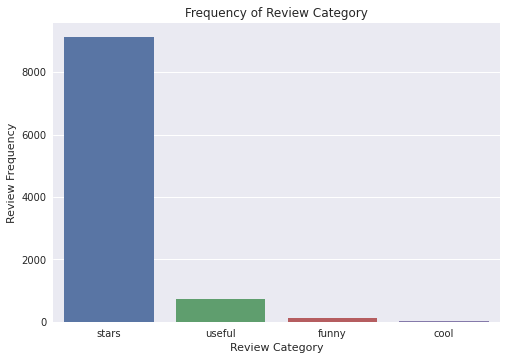

In [4]:
counted_labels = Counter(data.label)
sorted_counted_labels = {k:v for k,v in sorted(counted_labels.items(), reverse=True, key= lambda item: item[1])}

with plt.style.context('seaborn'):
    sns.barplot(x=list(sorted_counted_labels.keys()), y=list(sorted_counted_labels.values()))
    plt.ylabel('Review Frequency')
    plt.xlabel('Review Category')
    plt.title('Frequency of Review Category')

The process to clean the data includes removing punctuation, stop words, and lemmatizing words.

In [5]:
clean_punct_text = []
for review in data.text:
    review = review.lower()
    
    review = review.translate(str.maketrans('', '', string.punctuation))
    
    clean_punct_text.append(review)

In [6]:
stopwords = nlp.Defaults.stop_words

clean_no_stopwords = []
for review in clean_punct_text:
    review = set(review.split())
    clean_review = review.difference(stopwords)
    clean_no_stopwords.append(' '.join(clean_review))
    

Although the size of the data is smalle, it is kept in mind that a much larger sample than 1,000 will be used. Therefore, a spacy nlp pipeline is built for lemmatization that makes use of all available processes in batch sizes of 2,000.

In [7]:
lemmatize_reviews = []
for doc in nlp.pipe(clean_no_stopwords, disable=['parser','ner','textcat'], n_process=-1, batch_size=2000):
    temp_token_holder = [token.lemma_ for token in doc]
    lemmatize_reviews.append(' '.join(temp_token_holder))

Importing libraries for vectorization, encoding, and spliting dataset.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
count_vect = CountVectorizer()
le = LabelEncoder()

In [9]:
X_count_vect = count_vect.fit_transform(lemmatize_reviews)
y_label = le.fit_transform(data.label)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_count_vect, y_label, test_size=0.2, random_state=42)

To keep in mind the performance of training a dataset with limited resources multinomial naive bayes and a linear model with stochastic gradient descent. Benchmark metrics are imported as well.

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

Creating function to run all benchmarking metrics and visuals.

In [12]:
def metrics(y_test, y_pred, average='macro', classifier_labels=None):
    print('Accuracy: {}'.format(accuracy_score(y_test,y_pred)))
    print('Precision: {}'.format(precision_score(y_test,y_pred, average=average, zero_division=0)))
    print('Recall: {}'.format(recall_score(y_test,y_pred, average=average, zero_division=0)))
    print('F1 Score: {}'.format(f1_score(y_test,y_pred, average=average, zero_division=0)))
    if classifier_labels is not None:
        cm = confusion_matrix(y_test, y_pred, labels=classifier_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier_labels)
    else:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        
    disp.plot()

# Iteration 1

Creating instances of classifiers, fitting them and benchmarking them.

In [13]:
mnb = MultinomialNB()
sgd = SGDClassifier(n_jobs=-1)

In [14]:
mnb.fit(X_train,y_train)
mnb_prediction = mnb.predict(X_test)

Accuracy: 0.899
Precision: 0.3286318150448585
Recall: 0.2835230521336868
F1 Score: 0.29289557772344


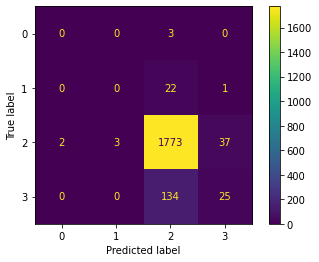

In [15]:
metrics(y_test, mnb_prediction, classifier_labels=mnb.classes_)

In [16]:
sgd.fit(X_train,y_train)
sgd_prediction = sgd.predict(X_test)

Accuracy: 0.8835
Precision: 0.30248602596465923
Recall: 0.29216435365663496
F1 Score: 0.29587793046511285


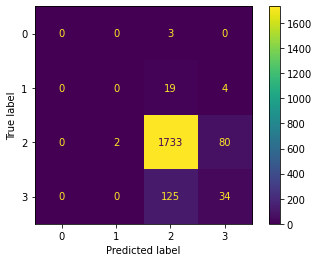

In [17]:
metrics(y_test, sgd_prediction, classifier_labels=sgd.classes_)

# Iteration 2

Using an undersampling strategy to balance data.

In [18]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()

In [19]:
X_train_oversample, y_train_oversample = ros.fit_resample(X_train,y_train)

In [20]:
mnb_oversample = MultinomialNB()
sgd_oversample = SGDClassifier(n_jobs=-1)

In [21]:
mnb_oversample.fit(X_train_oversample, y_train_oversample)
mnb_oversample_predictions = mnb_oversample.predict(X_test)

Accuracy: 0.8075
Precision: 0.28612620661705107
Recall: 0.32143822443993975
F1 Score: 0.29360845972223043


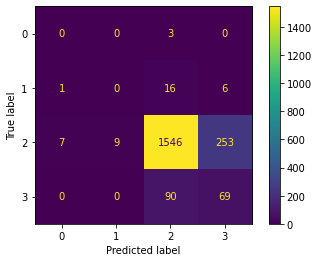

In [22]:
metrics(y_test,mnb_oversample_predictions, classifier_labels=mnb_oversample.classes_)

In [23]:
sgd_oversample.fit(X_train_oversample, y_train_oversample)
sgd_oversample_predictions = sgd_oversample.predict(X_test)

Accuracy: 0.8785
Precision: 0.30169947486644
Recall: 0.2993944591714746
F1 Score: 0.30030516637993215


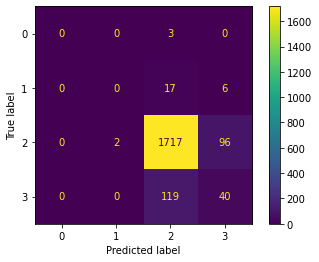

In [24]:
metrics(y_test,sgd_oversample_predictions, classifier_labels=sgd_oversample.classes_)

# Iteration 3

Reframing the quetion to "Will this review receive a star?"

Using complement naive bayes to create a binary model.

In [25]:
from sklearn.naive_bayes import ComplementNB

In [26]:
y_label_binary = [1 if i == 'stars' else 0 for i in data.label]

In [27]:
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_count_vect, y_label_binary, test_size=0.2, random_state=42)

In [28]:
cnb = ComplementNB()

In [29]:
cnb.fit(X_train_binary, y_train_binary)
cnb_predictions = cnb.predict(X_test_binary)

Accuracy: 0.875
Precision: 0.9264305177111717
Recall: 0.9366391184573003
F1 Score: 0.9315068493150686


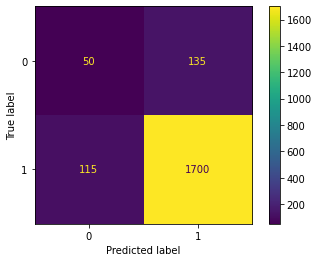

In [30]:
metrics(y_test_binary, cnb_predictions, average='binary', classifier_labels=cnb.classes_)

# Iteration 4

Continuation of binary modelling using term frequency inverse document frequency as a vectorizer.

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
tfid = TfidfTransformer()

In [32]:
x_tfid = tfid.fit_transform(X_count_vect)

In [33]:
X_train_tfid, X_test_tfid, y_train_tfid, y_test_tfid = train_test_split(x_tfid, y_label_binary, test_size=0.2, random_state=42)

In [34]:
tfid_cnb = ComplementNB()

In [35]:
tfid_cnb.fit(X_train_tfid, y_train_tfid)
tfid_cnb_preds = tfid_cnb.predict(X_test_tfid)

Accuracy: 0.902
Precision: 0.9069884364002011
Recall: 0.9939393939393939
F1 Score: 0.9484752891692955


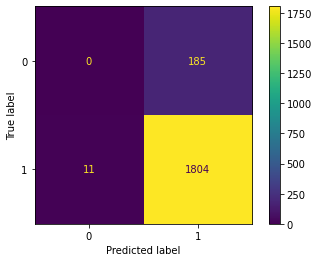

In [36]:
metrics(y_test_tfid, tfid_cnb_preds, average='binary')

# Iteration 5

Continuation of binary model with TF-IDF and using an under sampling strategy.

In [37]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()

In [38]:
x_train_tfid_u, y_train_tfid_u = rus.fit_resample(X_train_tfid, y_train_tfid)

In [39]:
tfid_cnb.fit(x_train_tfid_u, y_train_tfid_u)
tfid_cnb_preds = tfid_cnb.predict(X_test_tfid)

Accuracy: 0.5355
Precision: 0.9682875264270613
Recall: 0.5046831955922865
F1 Score: 0.6635277073524085


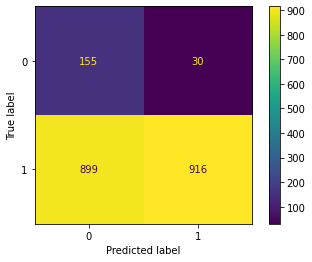

In [40]:
metrics(y_test_tfid, tfid_cnb_preds,'binary')

# Iteration 6

Using both an over sampling and under sampling strategy to increase the number of true negatives being classified correctly.

In [41]:
ros = RandomOverSampler(sampling_strategy=.8)
rus = RandomUnderSampler(sampling_strategy=.9)

In [42]:
X_train_combine, y_train_combine = ros.fit_resample(X_train_tfid, y_train_tfid)
X_train_combine, y_train_combine = rus.fit_resample(X_train_tfid, y_train_tfid)

In [43]:
tfid_cnb.fit(X_train_combine, y_train_combine)
tfid_cnb_preds = tfid_cnb.predict(X_test_tfid)

Accuracy: 0.674
Precision: 0.9655724579663731
Recall: 0.6644628099173554
F1 Score: 0.787206266318538


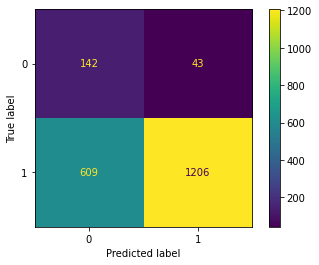

In [44]:
metrics(y_test_tfid, tfid_cnb_preds,'binary')